In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import json
import geopandas as gpd
from copy import deepcopy
import shapely
from shapely.geometry import Point,Polygon,LineString
import pyproj

### map of the 50 metro areas

In [2]:
# shape file for US metro areas
metromap = gpd.read_file("../data/shapes/tl_2019_us_cbsa/tl_2019_us_cbsa.shp")

In [3]:
# manipulations
metromap.set_geometry("geometry",inplace=True)

metromap["GEOID"] = metromap["GEOID"].astype(int)

In [4]:
# cbsa info table
cbsa_info = pd.read_csv("../data/cbsacode_shortname_tracts.csv", sep=";", index_col=0)

In [5]:
# manipulations
cbsa_info = cbsa_info.loc[:,["cbsacode", "short_name"]].drop_duplicates()
cbsa_info["selected"] = 1
cbsa_info["color"] = "darkblue"

In [10]:
# merge for plot
metromap = pd.merge(metromap, cbsa_info, left_on="GEOID", right_on="cbsacode", how="left")

In [11]:
# correction on the final dataframe
metromap["selected"] = metromap["selected"].fillna(0)
metromap["color"] = metromap["color"].fillna("lightgray")

In [12]:
# shape file for US states
usmap = gpd.read_file("../data/shapes/tl_2017_us_state/tl_2017_us_state.shp")

# manipulations
usmap.set_geometry("geometry",inplace=True)

### user numbers

In [89]:
# data IN -- edges are present both ways
geo_edgelist = pd.read_csv("../data/geo_edgelist_top50.csv.gz")

# degree
degree_tab = geo_edgelist.groupby("user_id1")["user_id2"].count().reset_index()
degree_tab.columns = ["user_id", "degree"]

# remove users with less than 10 ties (!!!) AND replace NANs
degree_tab = degree_tab[degree_tab["degree"]>=10] 
degree_tab = degree_tab.fillna(0)

# user and cbsa
users = geo_edgelist[["cbsacode", "user_id1"]].drop_duplicates()

# merge
degree_tab = pd.merge(degree_tab, users, left_on="user_id", right_on="user_id1", how="left")

# user count per cbsa
users_cbsa = degree_tab.groupby("cbsacode")["user_id"].count().reset_index()

In [90]:
# METRODATA

metrodata = pd.read_csv('../data/cbsa-est2018-alldata.csv', encoding = "ISO-8859-1")
metrodata = metrodata.drop_duplicates(subset=["CBSA"])

# keep relevant cbsacodes ONLY - sort by 2010 population
metrodata = metrodata.set_index("CBSA").loc[users_cbsa["cbsacode"].unique()].reset_index().sort_values(by="CENSUS2010POP",ascending=False)
metrodata = metrodata.reset_index().reset_index()[["level_0","CBSA","NAME","CENSUS2010POP"]]
metrodata.rename({"level_0":"rank","CBSA":"cbsacode","NAME":"name","CENSUS2010POP":"population"},axis=1,inplace=True)

# create short name for CBSAs
metrodata["short_name"] = metrodata["name"].map(lambda s: s.split("-")[0].split(",")[0])

metrodata.loc[metrodata.short_name == "Louisville/Jefferson County", "short_name"] = "Louisville"

# merge user counts
metrodata = pd.merge(users_cbsa, metrodata, on="cbsacode")
metrodata = metrodata.sort_values(by=['rank'])

In [ ]:
### combination

# general
import matplotlib.patches as mpatches
plt.rcParams['font.size']=16
plt.rc('legend',fontsize=22)
fig, ax = plt.subplots(2,1, figsize = (15,15), constrained_layout=True)


# MAP
usmap.plot(ax=ax[0], color="white", edgecolor='dimgray')
metromap.plot(ax=ax[0], column="selected", color=metromap["color"], edgecolor='dimgray')
ax[0].set_xlim([-127,-66])
ax[0].set_ylim([24,50])
ax[0].axis('off')

top50metro = mpatches.Patch(color='darkblue', label='Top 50 metro areas')
allmetro = mpatches.Patch(color='lightgray', label='Metro areas')
ax[0].legend(handles=[top50metro, allmetro], loc='lower left')


# distribution
ax[1].bar(metrodata["short_name"], metrodata["user_id"], color="darkblue")
ax[1].set_xticklabels(labels="", rotation=90)
ax[1].grid()
# ax[1].semilogy()
ax[1].set_xticklabels(labels=metrodata['short_name'], rotation=90)
ax[1].set_ylabel("Observed users", size=22)

plt.show()
# plt.savefig('../fig/map_users_top50.png', dpi=300, bbox_inches='tight')

### data representativity

In [19]:
# data IN -- edges are present both ways
geo_edgelist = pd.read_csv("../data/original_files/geo_edgelist_top50.csv.gz")

# degree
degree_tab = geo_edgelist.groupby("user_id1")["user_id2"].count().reset_index()
degree_tab.columns = ["user_id", "degree"]

# remove users with less than 10 ties (!!!) AND replace NANs
degree_tab = degree_tab[degree_tab["degree"]>=10] 
degree_tab = degree_tab.fillna(0)

# user and cbsa
users = geo_edgelist[["cbsacode", "user_id1"]].drop_duplicates()

# merge
degree_tab = pd.merge(degree_tab, users, left_on="user_id", right_on="user_id1", how="left")

# user count per cbsa
user_df = degree_tab.groupby("cbsacode")["user_id"].count().reset_index()
user_df.columns = ["cbsacode", "nr_users"]

In [26]:
# add observed users to metrodata
metrodata = pd.read_csv('../data/original_files/cbsa-est2018-alldata.csv', encoding = "ISO-8859-1")
metrodata = metrodata.drop_duplicates(subset=["CBSA"])

# keep relevant cbsacodes ONLY - sort by 2010 population
metrodata = metrodata.set_index("CBSA").loc[user_df["cbsacode"].unique()].reset_index().sort_values(by="CENSUS2010POP",ascending=False)
metrodata = metrodata.reset_index().reset_index()[["level_0","CBSA","NAME","CENSUS2010POP"]]
metrodata.rename({"level_0":"rank","CBSA":"cbsacode","NAME":"name","CENSUS2010POP":"population"},axis=1,inplace=True)

# create short name for CBSAs
metrodata["short_name"] = metrodata["name"].map(lambda s: s.split("-")[0].split(",")[0])

metrodata.loc[metrodata.short_name == "Louisville/Jefferson County", "short_name"] = "Louisville"

metrodata.set_index("cbsacode",inplace=True)
metrodata = metrodata.reset_index()

# user counts
metrodata = pd.merge(metrodata, user_df, on="cbsacode", how="left")

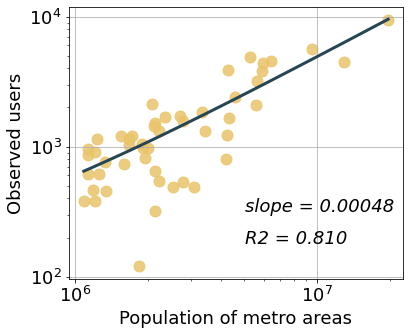

In [131]:
# SCATTER
plt.rcParams['font.size']=18
fig, ax = plt.subplots(figsize = (6,5))

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

X = (metrodata["population"]).values.reshape(-1, 1) 
Y = (metrodata["nr_users"]).values.reshape(-1, 1) 
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

plt.scatter(metrodata.population, metrodata.nr_users, s=120, color='#e9c46a', alpha=0.85)
plt.plot(X, Y_pred, color='#264653', linewidth=3)
plt.xlabel("Population of metro areas")
plt.ylabel("Observed users")
plt.loglog()
#plt.xlim([10**5.95, 10**7.3])
#plt.ylim([10**2.95, 10**4.5])

#slope = str("slope = " + linear_regressor.coef_)
plt.text(10**6.7, 10**2.5, ("slope = " + str(linear_regressor.coef_[0][0])[:7]), style='italic')
plt.text(10**6.7, 10**2.25, ("R2 = " + str(r2_score(Y, Y_pred))[:5]), style='italic')

plt.grid()
plt.show()
#plt.savefig('../fig/revision_SI_population_users.png',density=300,bbox_inches='tight')